# Tutorial 2: Building a first model

In tutorial 1, we got a basic understanding of our problem. We learned that the images show over 1000 different whales. For the majority of them exists only a single image. 
We also considered the score function that determins the placings on the leaderboard. Recall that our task is:

**For every image *i* in the *test_val* folder, predict the 20 images that are most similar to *i*.**

In this tutorial, we will build two solutions to this problem. Let's get started!

### Table of contents

[1. Similarity between Images](#section1) <br>
[2. A bit of history: The ImageNet Challenge](#section2) <br>
&emsp; [2.1 What is a Deep Learning Model for image classification](#section2.1) <br>
[3. On the shoulders of giants: Using pretrained model to convert images](#section3) <br>
[4. How to measure similarity](#section4) <br>
[5. Our baseline](#section5) <br>
[6. Learn, don't define: A better similarity measure](#section6) <br>
&emsp; [6.1 Examples for the AI: Creating image pairs ](#section6.1) <br>
&emsp; [6.2 Feeding examples to the AI ](#section6.2) <br>
&emsp; [6.3 Defining the model ](#section6.3) <br>
&emsp; [6.4 Training the model ](#section6.4) <br>
&emsp; [6.5 Creating predictions  ](#section6.5) <br>


In [1]:
# For readability, we list all libraries we use in this notebook at the beginning
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from matplotlib.pyplot import imshow
from pathlib import Path
from itertools import combinations
# from src.data.process_dataset import DataGeneratorFromEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt

## Data Generator Class

In [0]:
import random
from pathlib import Path

import numpy as np
from tensorflow.keras.utils import Sequence

EMBEDDING_SHAPE = 1024


class DataGeneratorFromEmbeddings(Sequence):
    """
    Takes a list of pairs and precomputed embeddings and labels
    and feeds them in batches to a deep learning model.
    """

    def __init__(
        self,
        pairs,
        embeddings,
        labels,
        batch_size=32,
        dim=EMBEDDING_SHAPE,
        shuffle=True,
    ):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.pairs = pairs
        self.embeddings = embeddings
        self.shuffle = shuffle
        self.indices = np.arange(len(self.pairs))
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        :return:
        """
        return int(np.floor(len(self.pairs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index:
        :return:
        """
        # Generate indexes of the batch
        indices = self.indices[
            index * self.batch_size : (index + 1) * self.batch_size
        ]
        # Find list of IDs
        pairs_temp = [self.pairs[k] for k in indices]
        # Generate data
        x, y = self.__data_generation(pairs_temp)
        return x, y

    def get_sample(self, index):
        """
        Gets one sample batch
        :param index:
        :return:
        """
        x, y = self.__getitem__(index)
        return x, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        :return:
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, pairs_temp):
        """
        Generates data containing batch_size samples
        :param pairs_temp:
        :return:
        """
        # Initialization
        x = [np.empty((self.batch_size, self.dim)) for i in range(2)]
        y = np.empty(self.batch_size, dtype=int)
        if self.labels is None:
            for i, pair in enumerate(pairs_temp):
                x[0][i,] = self.embeddings[pair[0]]
                x[1][i,] = self.embeddings[pair[1]]
        else:
            # Generate data
            for i, pair in enumerate(pairs_temp):
                # Store sample
                x[0][i,] = self.embeddings[pair[0][0]]
                x[1][i,] = self.embeddings[pair[1][0]]
                # Store class
                y[i] = self.labels[pair]
        return x, y


class BalancedDataGeneratorFromEmbeddings(Sequence):
    """
    Reads classes from the train_data_path,
    removes the -1 class and classes with one picture and
    creates batches containing a balanced amount of matching
    and non-matching samples.
    """

    def __init__(
        self,
        train_data_path,
        embeddings,
        batch_size=32,
        dim=EMBEDDING_SHAPE,
        shuffle=True,
    ):
        assert batch_size % 2 == 0, "Batch size must be an even number"
        self.train_data_path = Path(train_data_path)
        self.embeddings = embeddings
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.id_to_images, self.image_to_id = self.__parse_folder()
        self.indices = list(self.image_to_id.keys())
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        :return:
        """
        half_batch = self.batch_size / 2
        return int(np.floor(len(self.indices) / half_batch))

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index:
        :return:
        """
        # Generate indexes of the batch
        half_batch = int(self.batch_size / 2)
        start_index = index * half_batch
        end_index = start_index + half_batch
        images = self.indices[start_index:end_index]
        x, y = self.__data_generation(images)
        return x, y

    def get_sample(self, index):
        """
        Gets one sample batch
        :param index:
        :return:
        """
        x, y = self.__getitem__(index)
        return x, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        :return:
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __parse_folder(self):
        """
        Creates id_to_images and image_to_ids mappings.
        Ignores all whale ids with only one image and the -1 class
        :return:
        """
        id_folders = list(self.train_data_path.glob("*"))
        id_to_images = {}
        image_to_id = {}
        for folder in id_folders:
            if folder.name == "-1":
                continue
            pics = list(folder.glob("*.jpg"))
            if len(pics) == 1:
                continue
            id_to_images[folder.name] = {p.name for p in pics}
            for p in pics:
                image_to_id[p.name] = folder.name
        return id_to_images, image_to_id

    def __data_generation(self, images):
        """
        Generates data containing batch_size samples
        :param images:
        :return:
        """
        # Initialization
        x = [np.empty((self.batch_size, self.dim)) for _i in range(2)]
        y = np.empty(self.batch_size, dtype=int)
        # Generate data
        for i, image in enumerate(images):
            output_index = 2 * i

            # Store similar sample
            similar_img = self.__get_similar_image(image)
            x[0][output_index,] = self.embeddings[image]
            x[1][output_index,] = self.embeddings[similar_img]
            y[output_index] = 1

            # Store different sample
            different_img = self.__get_different_image(image)
            x[0][output_index + 1,] = self.embeddings[image]
            x[1][output_index + 1,] = self.embeddings[different_img]
            y[output_index + 1] = 0

        return x, y

    def __get_similar_image(self, image):
        """
        Returns an image of the same class than input image
        :param image: img file name to search for similar one
        :return: file name of similar image
        """
        image_id = self.image_to_id[image]
        potential_images = self.id_to_images[image_id].difference(set([image]))
        similar_image = random.sample(potential_images, 1)[0]
        return similar_image

    def __get_different_image(self, image):
        """
        Returns and image of a different class than input class
        :param image: class to exclude
        :return: file name for an image not in class img_id
        """
        image_id = self.image_to_id[image]
        while True:
            candidate = random.sample(self.indices, 1)[0]
            if self.image_to_id[candidate] != image_id:
                return candidate


<a id='section1'></a>
# Similarity between images

What makes two images similar? The colors? The shapes that appear? If you were to write an algorithm for it, how would you even start?

Let's start by considering how a machine sees a picture. For a computer, an image is essentially a 3-d matrix. Take for example one of our whale fluke images:

In [0]:
img_path = Path('../data/raw/Whale Watch Azores 2006/PM-WWA-20060929-070.JPG')
img = load_img(img_path)
print(img.layers)
print(img.size)

3
(900, 504)


The image has three layers, representing the colors red-green-blue (RGB), a width of 900 pixels and a height of 504 pixels.
For every pixel the RGB values are stored. Hence in total we get

In [0]:
3*900*504

1360800

values. We can also display images:

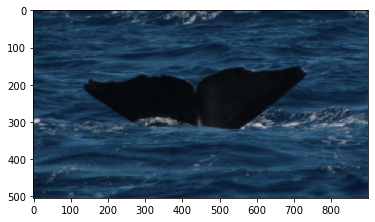

In [0]:
imshow(img_to_array(img, dtype=int))

Now we could *just* use a [matrix distance](https://math.stackexchange.com/questions/507742/distance-similarity-between-two-matrices) for computing the similarity. But this would put too much importance on individual pixels. In the end, we don't care if the water color is slightly different. What matters is the shape of the fluke! 

So how can we extract the *relevant* information in the image?

<a id='section2'></a>
## A bit of history: The ImageNet Challenge
Up until a few years ago computer vision was a very hard problem.
![An XKCD from 2014-09-24](https://imgs.xkcd.com/comics/tasks.png)
Since then, we made **immense** progress in this field. Tasks like image classification can nowadays be done with a few lines of code. In fact, this is one of the reasons why AI is so hyped nowadays.

All of this was made possible by advances in theory, hardware.. and data. But let's start with ImageNet.

### The ImageNet Challenge

>The ImageNet project is a large visual database designed for use in visual object recognition software research. More than 14 million images have been hand-annotated by the project to indicate what objects are pictured and in at least one million of the images, bounding boxes are also provided.ImageNet contains more than 20,000 categories with a typical category, such as "balloon" or "strawberry", consisting of several hundred images. -- From [Wikipedia](https://en.wikipedia.org/wiki/ImageNet)

The [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/) was a yearly competition based on the ImageNet dataset. The number of categories was reduced to 1000 and the participants had to create an algorithm that can detect the category of an image.

* Around 2011, a good error rate was 25%
* By 2015, the first algorithms exceeded human ability, which corresponds to an [5.1% error rate](https://arxiv.org/pdf/1705.02498.pdf) and 
* In 2018 the challenge was suspended. The problem was deemed *solved*

Thanks to the ImageNet challenge, we learned how to use *Deep Learning* to build models that can process images [better than humans](https://www.nature.com/articles/nature21056), given enough training data. Now you might argue that this is not really applicable in real life. After all, how often do you have millions of labelled pictures to train from? This is where the real benefit of ImageNet comes in!

As it turns out, models that are trained on ImageNet can be used as building blocks for visual applications. We can take a model that was trained on ImageNet and *fine-tune* it to a new application. This fine-tuning often only needs dozens of images to achieve acceptable to great performance.

<a id='section2.1'></a>
### What is a Deep Learning Model for image classification

At a very high level, a deep learning model is an [AI brain](https://towardsdatascience.com/a-gentle-introduction-to-neural-networks-series-part-1-2b90b87795bc). Like the human brain, it consists of (artificial) interconnected neurons. The strengh of the individual connection is defined by so called *weights*. Each model is build for a specific purpose. It takes an input (e.g. an image), processes it through all of its neurons, and finally creates an output (e.g. the probability that the image shows a dog). 

Researchers spend a lot of time finding the best *architecture*, i.e. the best way to connect different neurons. All successful deep learning model have one similarity: They are structured in layers, with each neuron taking the output of some of the neurons of the previous layer as input. The second-to-last layer, the last layer before the final output is called the *logits* layer. The logits are usually a vector of size 1024 and the final output of the model is a weighted linear combination of them.

![Deep-Learning-Tutorial-Sketch-v2a-TD.jpg](attachment:Deep-Learning-Tutorial-Sketch-v2a-TD.jpg)

This means that all the information of an image is compressed in a vector of size 1024. *Let that sink in.* 
In the example above, the image consisted 1.360.800 integers. With deep learning, we can compress it to 1024 floats while maintaining almost all of the relevant information in the image.

To summarize, a deep learning model consists of

* An architecture that defines how the different neurons are connected
* Weights that specify the importance of the individual connections

#### How does a model learn?

To *train* a model, we need two things. Examples and a measure that tells us how good we are. The rough process is as follows

* The model is initialized with random weights for the inter-neuron connections.
* We take one example, feed it into the model and compare the output with the expected output.
* If the predicted output is not the same as the expected output, we use [fancy math](https://en.wikipedia.org/wiki/Backpropagation) to change the weights a tiny bit so that the predicted output is a bit closer to the expected output.
* We iterate the previous step thousands of times. If everything went well, all the tiny changes to the weights lead to a model that creates predictions that are very close to the expected values.

![Deep-Learning-Tutorial-Sketch-v2b-TD.jpg](attachment:Deep-Learning-Tutorial-Sketch-v2b-TD.jpg)

This short introduction barely scratches the surface. There is a lot more to learn and we highly recommend to take one of the many good [online courses on deep learning](https://www.deeplearning.ai/deep-learning-specialization/).

<a id='section3'></a>
## On the shoulders of giants: Using pretrained model to convert images

As described in the previous section, pre-trained deep learning models allow us to convert an image to a vector of size 1024 that contains the relevant information in the image. In this section, you'll learn how to do this.

We'll use a model called [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) that was trained on the ImageNet dataset for a first test. MobileNet is a second generation model that trades accuracy for speed. I.e. the vector representation will not be the best, but it will run on our laptops.
In the next tutorial we will show you how to use AWS to take advantage of [more advanced models](https://keras.io/applications/) and even train your own models.

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
mobilenet = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step


The options *include_top=False* and *pooling='avg'* are necessary to extract the *logits* layer. 
The *input_shape* defines the size of the images. The default for ImageNet models is 224x224 pixels with 3 channels for colors.
We can check out the architecture of the model with the *summary* function.

In [4]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

Note that the number of parameters is over 3 million! This might seem like a lot, but [state-of-the-art models](https://paperswithcode.com/task/image-classification) can have over 100 million parameters.

To convert our example image we load the image, rescale it to 224x224 pixel and change the format to the right datatype.

In [0]:
img_path = Path('../data/raw/Whale Watch Azores 2006/PM-WWA-20060929-070.JPG')
img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # The standard size for ImageNet trained models is 224x224 pixels.
img_array = img_to_array(img)  # Convert the image to an array
img_array_expanded_dims = np.expand_dims(img_array, axis=0)  # Add additional dimension for the model

Then we can convert the image to a vector of size 1024

In [0]:
image_converted_wrong_shape = mobilenet.predict(img_array_expanded_dims)  # Run the image through the model 
image_converted = np.reshape(image_converted_wrong_shape, -1)  # Remove unnecessary dimension
image_converted.shape  # Shows the dimensions of an array

(1024,)

And voila, we just implemented a first method to extract *relevant* information of an image. 
With this we can refer back to our initial question: How can we measure similarity between images?

<a id='section4'></a>
## How to measure similarity

As usual there are multiple ways to measure similarity between vectors. A good first start is the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) which measures the cosine of the angle between two vectors.
It is equal to 

* −1, if the vectors are opposite
* 0, if they are orthogonal
* 1, if they are exactly the same

Luckily for us, [sklearn](https://scikit-learn.org/stable/index.html) has a function just for this, aptly called [cosine_similiarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

Assume we have the vectors [1,0] and [0,1] then the cosine similarity between the two is 0:

In [0]:
vec_a = [1,0]
vec_b = [0,1]
cosine_similarity([vec_a], [vec_b])

array([[0.]])

and the cosine similarity between a vector and itself is 1

In [0]:
cosine_similarity([vec_a], [vec_a])

array([[1.]])

and we can even compute the similarity for multiple vectors at once

In [0]:
cosine_similarity([vec_a, vec_b], [vec_a, vec_b])

array([[1., 0.],
       [0., 1.]])

With this, we have all the ingredients for a first baseline model!

<a id='section5'></a>
## Our baseline model

Now that we are aware of the concept, we are one step closer to our first submission. We will 

- use Mobilenet to compute the embeddings for all of the train and test pictures 
- calculate the cosine similarity between each of the embeddings of the test pictures and the embeddings of the train pictures
- create a submission that predicts the 20 matches with the highest similarity score

We start with loading all pictures with [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).As first step we are going to list all file paths and names.

In [0]:
train_data_path = Path('../data/train')
train_files_paths = list(train_data_path.glob('*/*.jpg'))  # All file paths
train_files_names = [p.name for p in train_files_paths]  # Only the file names without the full path
train_files_classes = [p.parent.name for p in train_files_paths]  # The parent directory, i.e. the whale ID, for each image

test_data_path = Path('../data/test_val')
test_files_paths = list(test_data_path.glob('*.jpg'))
test_files_names = [p.name for p in test_files_paths]

To load a single picture we have to read the file, convert it into a [tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor) object, adjust the size and standardize it to the MobileNet input format.

In [0]:
BATCH_SIZE = 32

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img

Now that we have defined the prerequisites to load a single picture, we can apply it to all of our pictures. We create a dataset from our input data paths and apply the defined function to each entry in the dataset.

The batch size specifies the number of examples we use in one iteration of calcuation. For now you can ignore it. It will become more relevant later.

# Data Loading

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
pip install -U tqdm

     |████████████████████████████████| 61kB 3.2MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [8]:
%cd /content/drive/My Drive/Colab Notebooks/I&D_Whale/data/

/content/drive/My Drive/Colab Notebooks/I&D_Whale/data


In [0]:
import pandas as pd

In [12]:
t1 = pd.read_csv('final_train.csv')
t2 = pd.read_csv('test.csv')
a = t1[['Image', 'fil_path']]
a['type'] = 'train'
b = t2[['Image', 'fil_path']]
b['type'] = 'test'
df = pd.concat([a, b], ignore_index=True, sort=False)
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Image,fil_path,type
0,PM-WWA-20050413-003b.jpg,train/2764/PM-WWA-20050413-003b.jpg,train
1,PM-WWA-20050413-029.jpg,train/2764/PM-WWA-20050413-029.jpg,train
2,PM-WWA-20050413-006.jpg,train/2825/PM-WWA-20050413-006.jpg,train
3,PM-WWA-20050413-007.jpg,train/2825/PM-WWA-20050413-007.jpg,train
4,PM-WWA-20050413-009.jpg,train/2826/PM-WWA-20050413-009.jpg,train


In [0]:
from tqdm.auto import tqdm
tqdm.pandas()

In [15]:
df['vector'] = df['fil_path'].progress_apply(load_image)

In [16]:
df.head()

,Image,fil_path,type,vector
0,PM-WWA-20050413-003b.jpg,train/2764/PM-WWA-20050413-003b.jpg,train,"Tensor(""sub:0"", shape=(224, 224, 3), dtype=flo..."
1,PM-WWA-20050413-029.jpg,train/2764/PM-WWA-20050413-029.jpg,train,"Tensor(""sub_1:0"", shape=(224, 224, 3), dtype=f..."
2,PM-WWA-20050413-006.jpg,train/2825/PM-WWA-20050413-006.jpg,train,"Tensor(""sub_2:0"", shape=(224, 224, 3), dtype=f..."
3,PM-WWA-20050413-007.jpg,train/2825/PM-WWA-20050413-007.jpg,train,"Tensor(""sub_3:0"", shape=(224, 224, 3), dtype=f..."
4,PM-WWA-20050413-009.jpg,train/2826/PM-WWA-20050413-009.jpg,train,"Tensor(""sub_4:0"", shape=(224, 224, 3), dtype=f..."


In [26]:
train_files = df['fil_path'].progress_apply(lambda x : tf.data.Dataset.from_tensor_slices(list(map(str, x))))

In [28]:
train_files[0]

<DatasetV1Adapter shapes: (), types: tf.string>

In [29]:
# train_files = tf.data.Dataset.from_tensor_slices(list(map(str, train_files_paths)))  # Convert paths to strings
train_ds = train_files.map(load_image)  # Apply the load_image function to every image
train_ds = train_ds.batch(BATCH_SIZE)  # Set the batch size

# test_files = tf.data.Dataset.from_tensor_slices(list(map(str, test_files_paths)))
# test_ds = test_files.map(load_image)
# test_ds = test_ds.batch(BATCH_SIZE)

TypeError: ignored

To calculate the embeddings we use the Mobilenet. This will take a while, so time to grab a coffe while this is running :) 

In [24]:
%%time
embed_train = mobilenet.predict(df['vector'], batch_size=32)
# embed_test = mobilenet.predict(test_ds)

ValueError: ignored

In [22]:
k = df['vector'].apply(_pred)

ValueError: ignored

In [0]:
print(f'Shape of training embeddings {embed_train.shape}')
print(f'Shape of test embeddings {embed_test.shape}')

Shape of training embeddings (4532, 1024)
Shape of test embeddings (808, 1024)


For every picture we have now the representation as a vector with a size of 1024. We can calculate the cosine similarity between all of them.

In [0]:
all_names = np.concatenate((train_files_names, test_files_names))  # Combine the train and test data
all_paths = np.concatenate((train_files_paths, test_files_paths))
embed_all = np.concatenate((embed_train, embed_test))
print(f'Shape of all embeddings {embed_all.shape}')

Shape of all embeddings (5340, 1024)


In [0]:
similarity_matrix = cosine_similarity(embed_test, embed_all)
print(f'Shape of the similarity matrix {similarity_matrix.shape}')

Shape of the similarity matrix (808, 5340)


For each of the 808 pictures in the test dataset we have the similarity to each of the 5340 other picutres. Let us take a look at one example.

In [0]:
index_1 = 666
index_2 = 2656
print(f'The cosine similarity of picture {index_1} and {index_2} is {similarity_matrix[index_1, index_2]}')

The cosine similarity of picture 666 and 2656 is 0.5091471076011658


And also at the two respective pictures

In [0]:
def show_images(img_paths):
    plt.figure(figsize=(30, 30))
    image_count = len(img_paths)
    for path, n in zip(img_paths, range(image_count)):
        ax = plt.subplot(image_count, 4, n + 1)
        img = load_img(path)
        plt.imshow(img)
        plt.title(f'{path.name}, class: {path.parent.name}')

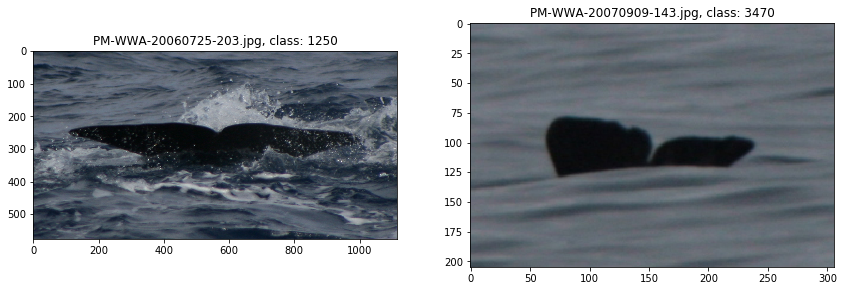

In [0]:
show_images([all_paths[index_1], all_paths[index_2]])

To create a submission, we sort the similarities in descending order and write the twenty most similar pictures in to a file. We use the [np.argsort](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) function, which will return the indices to sort our matrix column-wise in ascending order. Since we want to have the direction descending, we will put a **-** before the similarity matrix.

In [0]:
indices = np.argsort(-similarity_matrix, axis=1)

Recall that the format for a submissions is

*test_pic, predicted_pic_1, predicted_pic_2, ...., predicted_pic_20*

The cosine similarity between a picture and itself is always 1.0. Hence the most similar image is always the image itself and we can create a submission as follows:

In [0]:
with open('cosine_preds.csv', 'w') as f:
    for i in range(len(test_files_names)):
        indices_of_top_predictions = indices[i,:21]  # Get the indices of the 21 most similar images
        names_of_top_predictions = all_names[indices_of_top_predictions]  # Get the file names of the 21 most similar images
        preds = ','.join(names_of_top_predictions)  # Put a , between the image names
        f.write(preds + '\n')  # Write it in a new line

When we upload the submission we get a score of *83.00*. 

<font color='blue'>

**Best practice:** 
- Deep Learning models are state-of-the-art for almost every image-type problem
- You can use pretrained models to compress the data in an image
- The cosine is an good baseline for similarity between vectors
- When tackling an AI problem, always start with a simple model. This is called the baseline model

<a id='section6'></a>
# Learn, don't define: A better similarity measure

The baseline model took existing concepts and applied them to our problem. In other words, we took a standard software-engineering approach. The drawback of this approach is that that we have to manually define every single step. 

Now let us solve the problem with artificial intelligence, or rather machine learning. Here's the battle plan:

- Goal: Our model should learn whether or not two images show the same whale.
- Data: Create a dataset of images pairs and a label that denotes if the two images show the same whale.
- Architecture: A [Siamese Twin Network](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) fits perfectly to our use case

![siamese](https://miro.medium.com/max/1531/1*dFY5gx-Vze3micJ0AMVp0A.jpeg)

As the image illustrates, a Siamese Twin Network 

- takes two images as input
- embeds them via a convolutional neural network
- computes the absolute difference between the two embeddings
- predicts whether or not the images are equal based on the difference.

Note that our baseline model is very similar to the siamese twin approach. We computed embeddings with MobileNet and instead of learning the similarity from the absolute difference of the embeddings we used the cosine similarity.

*For our next model, we'll keep the MobileNet embeddings and replace the cosine similarity with a learned distance function.*

<font color='blue'>
    
**Best practice:** 
    
- Create an architecture image to illustrate and discuss deep learning models
- Learn the different types of layers and when to use them

<a id='section6.1'></a>
## Examples for the AI: Creating image pairs 

For the input we need to create pairs of images with a label that is *1* if the images show the same whale and *0* if the images show a different whale. First we create pairs of images with the [combinations](https://stackoverflow.com/questions/942543/operation-on-every-pair-of-element-in-a-list) function.

**Exercise:** Read up on how exactly the *combinations* works. Is this the best way to create image pairs? 

In [0]:
train_pairs = list(combinations(zip(train_files_names, train_files_classes), 2))

*train_pairs* consists of tuples where the first entry is the name of the file and the second the corresponding class. E.g.

In [0]:
train_pairs[0]

(('PM-WWA-20050416-037.jpg', '-1'), ('PM-WWA-20050513-229.jpg', '-1'))

Now we can add the information about the similarity. Two images are similar [iff](https://en.wikipedia.org/wiki/If_and_only_if) they have the same class.

In [0]:
def is_similar(pair):
    image_one_class = pair[0][1]
    image_two_class = pair[1][1]
    if image_one_class == image_two_class:
        return 1
    else:
        return 0

In [0]:
train_labels = {pair: is_similar(pair) for pair in train_pairs}

In the example pair from above, both images have the class *-1*. Hence the corresponding label is *1*.

In [0]:
train_labels[train_pairs[0]]

1

<a id='section6.2'></a>
## Feeding examples to the AI
Now we have all the information we need and we can start loading the pictures. Since the size of our data might not fit into RAM all at once, we are using the [DataGenerator](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) class that Keras offers. The DataGenerator class continuously loads our data during the training process.
In order to do modelling, we have to define on which data our model can train on. 

In [0]:
train_embeddings = {img: embedding for img, embedding in zip(train_files_names, embed_train)}

To speed up the computations, we create a dictionary, i.e. a lookup table, that given the name of a image file returns the precomputed embedding. Together with the pairs and labels we created in the previous section, we can create our own *DataGenerator*.
The details will be covered in the next tutorial. If you can't wait, the source code lies in *src.data.process_dataset.py*.

In [0]:
train_generator = DataGeneratorFromEmbeddings(train_pairs, train_embeddings, train_labels)

A *DataGenerator* creates tupels of inputs (i.e. embeddings) and expected outputs (i.e. labels) that we can use to train our model. Let us take a look on one example. Per default, one sample consists of 32 embeddings and labels.

In [0]:
embeddings, labels = train_generator.get_sample(0)
print(f'The loaded pictures are in shape {embeddings[0].shape}')
print(f'The loaded labels are in shape {labels.shape}')

The loaded pictures are in shape (32, 1024)
The loaded labels are in shape (32,)


<font color='blue'>
    
**Best practice:** 
    
- Use a DataGenerator to feed data into your model. 
- Deep Learning uses a lot of resources. Precomputing and caching data can save a lot of time.
- Split the data into a [train and validation subset](https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets) to evaluate the performance of your model during the training.

**Exercise:** Split the data into train and test set.

<a id='section6.3'></a>
## Defining the model
The next step in our process is the turn the image into an actual model. The following code defines a model that implements the siamese twin network shown above and compiles it.

*Note: Usually, you do not need to compile Python code. Tensorflow models are an exception since they are focussed on performance.*

In [0]:
EMBED_LENGTH = 1024

def siamese_net_from_embeddings(learning_rate):    
    """
    Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    input_shape = [EMBED_LENGTH]
    embeddings_1 = Input(input_shape)
    embeddings_2 = Input(input_shape)

    # Add a customized layer to compute the absolute difference between the encodings 
    absolute_difference = tf.math.abs(embeddings_1 - embeddings_2)
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    similarity_score = Dense(1, activation='sigmoid', 
                       bias_initializer=RandomNormal(mean=0.5, stddev=0.01, seed=None))(absolute_difference)
    
    siamese_net = Model(inputs=[embeddings_1,embeddings_2], outputs=similarity_score)
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    return siamese_net

To create an actual instance of the model, we only need to specify the [learning rate](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10). The *summary* function gives an overview of our creation.

In [0]:
learning_rate = 0.0001
model = siamese_net_from_embeddings(learning_rate)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2020-02-24 23:33:34,710 deprecation new_func line 506 From c:\users\dkuehlwe\pycharmprojects\global_data_science_challenge_3\venv\lib\site-packages\tensorflow_core\python\keras\initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2020-02-24 23:33:34,785 deprecation new_func line 323 From c:\users\dkuehlwe\pycharmprojects\global_data_science_challenge_3\venv\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 1024)]       0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Abs (TensorFlowOpLa [(None, 1024)]       0           tf_op_layer_sub[0][0]        

Et voila, we just created our first deep learning model with a measly 1025 different parameters that need to be learned.

<a id='section6.4'></a>
## Training the model
To make the model learn, we pass image, label pairs to the model. We just have to define the number of times the model is trained with our pairs. This is done with the following parameters

* *batch size* is the number of examples used in one training iteration. A higher number leads to more robust results. 
* *epochs* is the number of iterations
* *steps_per_epoch* is the number of batches the model considers per epoch

Recall that, we are giving the images as the input to our model and compare the output with the expected output (our label). To measure how good the model is in the current training period, we are using the [binary cross-entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) loss. 

In [0]:
model.fit_generator(train_generator, steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2101 - acc: 0.9509
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0965 - acc: 0.9834
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1108 - acc: 0.9791
Epoch 4/10
100/100 [==============================] - 0s 5ms/step - loss: 0.0826 - acc: 0.9850
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0783 - acc: 0.9859
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0937 - acc: 0.9806
Epoch 7/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0685 - acc: 0.9869
Epoch 8/10
100/100 [==============================] - 0s 5ms/step - loss: 0.0763 - acc: 0.9850
Epoch 9/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0847 - acc: 0.9822
Epoch 10/10
100/100 [==============================] - 0s 3ms/step - loss: 0.0765 - acc: 0.9834


Figuring out the right now for *epochs*, *steps_per_epoch* and *batch_size* and *learning_rate* is a science in itself.
In general, when there are only minor changes in loss and acc, either stop the training or decrease the learning rate.

<font color='blue'>
    
**Best practice:** 
    
- When there are only minor changes in loss and acc, either stop the training or decrease the learning rate.
- When you set up a separate validation, stop training once the loss and acc is worse on validation than on the training data set. In this case you started to [overfit](https://en.wikipedia.org/wiki/Overfitting)
- Keep track of all the results you get!

<a id='section6.5'></a>
## Creating predictions 
Our model is trained and we can now use it to make predictions to the *test_val* dataset. 

In [0]:
all_embeddings = {img: embedding for img, embedding in zip(all_names, embed_all)}
all_file_count = len(all_embeddings)

The compute the predictions for a single image, we need to pair it with every other image

In [0]:
test_file_name = test_files_names[0]
mask = all_names != test_file_name  
all_other_images = all_names[mask]  # Filter out the test_file_name with the mask
assert len(all_other_images) == (all_file_count - 1)  # Use asserts to quickly check assumptions  
test_file_pairs = [(test_file_name, other_image) for other_image in all_other_images]  

And then create a new DataGenerator to create the actual predictions. 

**Important**: To ensure, that we are predicting for each pair only one similarity, the batch size has to be a multiple of the number of pairs.

In [0]:
%%time
prediction_generator = DataGeneratorFromEmbeddings(test_file_pairs, all_embeddings, labels=None, batch_size=19, shuffle=False)
predictions = model.predict_generator(prediction_generator)

Wall time: 808 ms


As before, we use *argsort* to sort the results and extract the top 20 predictions

In [0]:
indices = np.argsort(-predictions, axis=0)
names_of_top_predictions = all_other_images[indices[:20]]

With the individual steps working, we can now compute the predictions for every test image

In [0]:
%%time
siamese_distance_only_preds = []
for test_file_name in test_files_names:
    mask = all_names != test_file_name
    all_other_images = all_names[mask]  
    assert len(all_other_images) == (all_file_count - 1)   
    test_file_pairs = [(test_file_name, other_image) for other_image in all_other_images]  
    
    prediction_generator = DataGeneratorFromEmbeddings(test_file_pairs, all_embeddings, labels=None, batch_size=19, shuffle=False)
    predictions = model.predict_generator(prediction_generator)
    
    indices = np.argsort(-predictions, axis=0)
    names_of_top_predictions = all_other_images[indices[:20].reshape(-1)]
    siamese_distance_only_preds.append(np.concatenate(([test_file_name], names_of_top_predictions)))

Wall time: 10min 56s


And create a new submission file

In [0]:
with open('siamese_distance_only_preds.csv', 'w') as f:
    for entry in siamese_distance_only_preds:
        preds = ','.join(entry)  
        f.write(preds + '\n')  

Upon uploading the file, we get a score of *16.01* which is **worse than our baseline**.
What is going on?

**Excercise:**
- Figure out the mistakes we did when training the model and fix them.

<font color='blue'>
    
**Best practice:** 
    
- If your results are worse than your baseline, you probably made a very basic mistake.

# Summary
In this tutorial we learned about deep learning and how it revolutionized image processing.
We build a baseline model based on image embeddings and the cosine similarity and finally trained a first deep learning model.
Unfortunately, the results we got were worse than our baseline.

In the next tutorial we will
- Analyse and fix the problems in our current model
- Learn how to use AWS to train larger and better models
- Discuss potential further improvements